In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [3]:
# for name in dir():
#     if not name.startswith('_'):
#         del globals()[name]

In [4]:
# ============= Import required packaages ==============
import time

# Import all custom variables and modules
from custom_classes_defs.preprocessing import *
# from custom_classes_defs.Unet_like import *  
# from custom_classes_defs.unet import *  
from custom_classes_defs.fnet import *
# from custom_classes_defs.ae import *

RND_STATE = 247
BATCH_SIZE = 512
keras.utils.set_random_seed(RND_STATE)
from keras.utils import plot_model

INTERACTIVE_SESSION = True

# -------------------------------------------------------

2024-05-06 17:33:43.734797: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-06 17:33:44.514888: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 17:33:44.515310: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 17:33:44.624462: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-06 17:33:44.845391: I tensorflow/core/platform/cpu_feature_guar

In [5]:
# Verify tensorflow/keras versions
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

# Verify CPU/GPU availability
print(tf.config.list_physical_devices())
NUM_GPU = len(tf.config.list_physical_devices('GPU'))
print(f"Number of GPUs assigned for computation: {NUM_GPU}")

if NUM_GPU:
    # print GPU info
    !nvidia-smi

tensorflow version: 2.15.0
keras version: 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs assigned for computation: 1
/usr/local/bin/bash: /opt/miniconda3-py311/lib/libtinfo.so.6: no version information available (required by /usr/local/bin/bash)


Mon May  6 17:34:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:3B:00.0 Off |                    0 |
| N/A   32C    P0              32W / 250W |      4MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

### Data preparation and model configurations

In [6]:
print("{}\n\t{}\n{}".format('='*55,'Data preparation and model configurations', '-'*55))
# Hand-written alphabet images
start = time.time()
if 'letters' not in dir():
    letters = MNIST_letters(
        './data/az_handwritten_alphabets_in_csv_format/A_Z_Handwritten_Data.csv',
    )
    
# # Preprocessing and normalization

# Load data (split ratio = train:val:test = 5:1:4)
(x_train, _), (x_test, _), (x_val, _) = \
    letters.split_data(train_ratio=0.5, val_ratio=0.1)

print("Shape of dataset: {}".format(str(letters.df.shape)))
print("Shape of training data: {}".format(str(x_train.shape)))
print("Shape of validation data: {}".format(str(x_val.shape)))
print("Shape of test data: {}".format(str(x_test.shape))) 

# Create data generator for respective data samples and labels
train_dataset = letters.data_generator(x_train, batch_size=BATCH_SIZE, cache=NUM_GPU) 
val_dataset = letters.data_generator(x_val, batch_size=BATCH_SIZE, cache=NUM_GPU) 
x_test, y_test = letters.data_generator(x_test, as_numpy=True)
        
print("Train Dataset:", train_dataset)
print('...elapsed time: ___{:5.2f} minutes___'.format((time.time()-start) / 60))

	Data preparation and model configurations
-------------------------------------------------------


Shape of dataset: (144013, 784)
Shape of training data: (72006, 28, 28)
Shape of validation data: (14402, 28, 28)
Shape of test data: (57605, 28, 28)


2024-05-06 17:34:46.045094: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38374 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0


Train Dataset: <CacheDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 28, 28, 1), dtype=tf.uint8, name=None))>
...elapsed time: ___ 0.49 minutes___


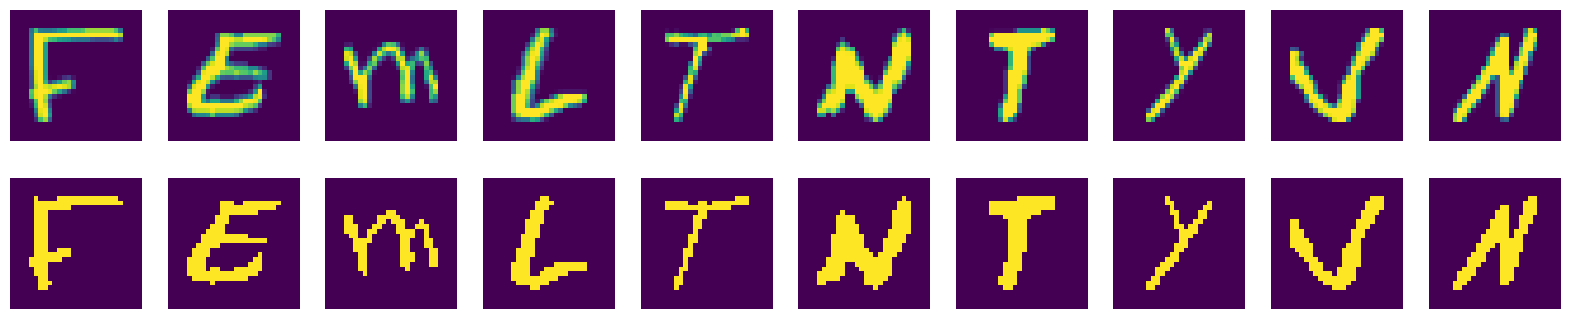

In [7]:
display_sample_images(x_test, y_test, img_shape=(28,28))

In [8]:
x_test.shape[0] // BATCH_SIZE

112

In [9]:

# Model configurations
conf = model_config(
    epochs=100,
    batch_size=BATCH_SIZE,
    shuffle=True,
    scaling=1,
    save_path='./mnist-letters/fnet',
    threshold=letters.threshold,
    pos_label=letters.pos_label,
    new_training_session=True,
    multiple_gpu_device=(NUM_GPU>1),
    train_size=letters.train_sise,
    test_size=letters.test_size,
    validation_size=letters.validation_size
)


callbacks = conf.callbacks(
    chkpt_monitor='val_f1_score', 
    es_monitor='val_loss',
    es_patience=15, 
    lr_monitor='val_loss',
    lr_patience=5,
)
conf.set( validation_data=val_dataset,  callbacks=callbacks )
m1 = f1_score(positive_label=letters.pos_label, threshold=letters.threshold)
conf.set(
    'compile',
    metrics= ['accuracy', m1]
)

# conf.double_check(INTERACTIVE_SESSION)
conf.info()

             NUM_GPU: 1
        augmentation: False
        channels_dim: (1, 1)
        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
                       metrics: accuracy
                              : f1_score(name=f1_score,dtype=float32)
           img_shape: (28, 28)
              labels: ListWrapper([0, 1])
     mixed_precision: None
          model_arch:
                     img_shape: (28, 28)
                   target_size: (28, 28)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
 multiple_gpu_device: False
new_training_session: True
           pos_label: 1
           save_path: ./mnist-letters/fnet
             scaling: 1
         target_size: (28, 28)
           test_size: None
           threshold: 0.5
          train_size: None
       training_args:
                        epochs: 100
                    batch_size: 512
                       shuffle:

### Build  model 

In [10]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))

if conf.multiple_gpu_device:

    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of devices: {strategy.num_replicas_in_sync}")
    with strategy.scope():
        # m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
        m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
        model = m_obj.build_model()
        model.compile(**conf.compile_args)

else:

    # m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
    m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
    model = m_obj.build_model()
    model.compile(**conf.compile_args)


# model.summary()
# keras.utils.plot_model(model, 'm_obj.png',show_shapes=True)
# plot_model(model, 'm_obj.png',show_shapes=True)
num_trainable_weights = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total number of parameters: {model.count_params():,}")
print(f"Total trainable wieghts: {num_trainable_weights:,}")
print(f"Total non-trainable wieghts: {model.count_params()-num_trainable_weights:,}")





	Build model
-------------------------------------------------------
inputs padded by 2 to fit model design


Cropping the output by 2 to fit input...
Total number of parameters: 12,218,241
Total trainable wieghts: 12,203,969
Total non-trainable wieghts: 14,272


### Train  model



	Train fnet model
-------------------------------------------------------
Model training...


2024-05-06 17:35:23.062286: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inF-NET/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2024-05-06 17:35:26.404460: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


2024-05-06 17:35:39.136708: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f47e90b83c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-06 17:35:39.136766: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-05-06 17:35:39.256344: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


I0000 00:00:1715009740.203120 1513615 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 55: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



Epoch 62: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.



Epoch 72: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.



Epoch 85: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.



Epoch 90: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.



Epoch 97: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.


training elapsed time: ___22.12___ minutes
...training completed!


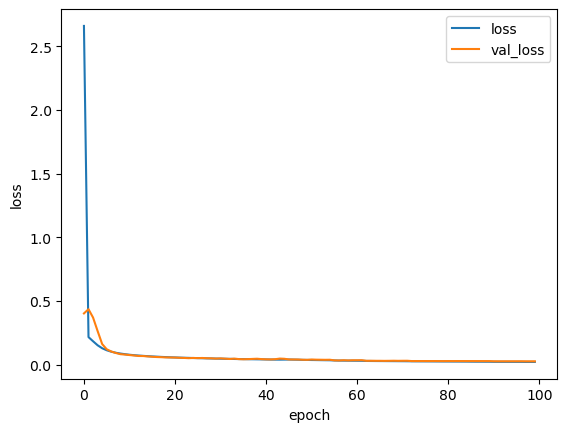

In [11]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

model, train_history = \
    conf.execute_training(
        model, 
        data=train_dataset, 
        plot_history=INTERACTIVE_SESSION
)


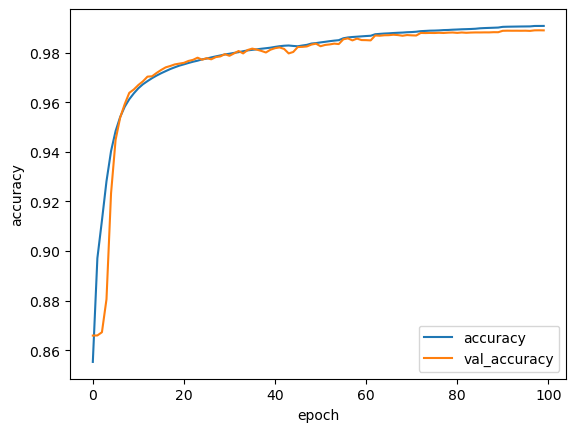

In [12]:
show_convergence(train_history.history, ['accuracy','val_accuracy'])

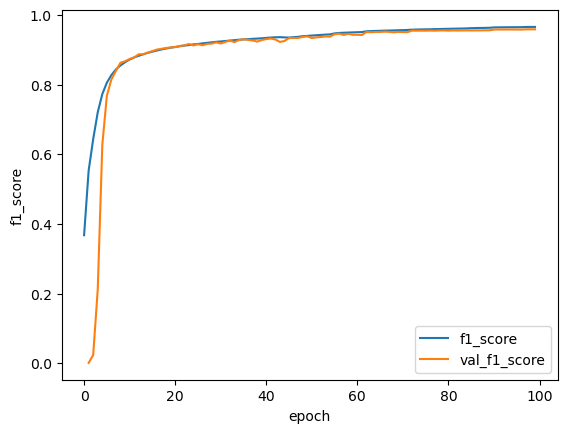

In [13]:
show_convergence(train_history.history, ['f1_score','val_f1_score'])

### Evaluate and Vizualize

In [14]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Evaluate {m_obj.Name} model', '-'*55))
decoded_imgs = model.predict(x_test)




	Evaluate fnet model
-------------------------------------------------------


   1/1801 [..............................] - ETA: 1:01:50

   5/1801 [..............................] - ETA: 24s    

  10/1801 [..............................] - ETA: 22s

  14/1801 [..............................] - ETA: 22s

  19/1801 [..............................] - ETA: 21s

  24/1801 [..............................] - ETA: 21s

  28/1801 [..............................] - ETA: 21s

  33/1801 [..............................] - ETA: 21s

  36/1801 [..............................] - ETA: 22s

  41/1801 [..............................] - ETA: 21s

  45/1801 [..............................] - ETA: 21s

  49/1801 [..............................] - ETA: 21s

  54/1801 [..............................] - ETA: 21s

  59/1801 [..............................] - ETA: 21s

  63/1801 [>.............................] - ETA: 21s

  68/1801 [>.............................] - ETA: 21s

  73/1801 [>.............................] - ETA: 21s

  78/1801 [>.............................] - ETA: 21s

  83/1801 [>.............................] - ETA: 21s

  89/1801 [>.............................] - ETA: 20s

  93/1801 [>.............................] - ETA: 20s

  98/1801 [>.............................] - ETA: 20s

 102/1801 [>.............................] - ETA: 20s

 106/1801 [>.............................] - ETA: 20s

 112/1801 [>.............................] - ETA: 20s

 117/1801 [>.............................] - ETA: 20s

 122/1801 [=>............................] - ETA: 20s

 127/1801 [=>............................] - ETA: 20s

 131/1801 [=>............................] - ETA: 20s

 137/1801 [=>............................] - ETA: 19s

 142/1801 [=>............................] - ETA: 19s

 146/1801 [=>............................] - ETA: 19s

 151/1801 [=>............................] - ETA: 19s

 156/1801 [=>............................] - ETA: 19s

 161/1801 [=>............................] - ETA: 19s

 166/1801 [=>............................] - ETA: 19s

 171/1801 [=>............................] - ETA: 19s

 177/1801 [=>............................] - ETA: 19s

 182/1801 [==>...........................] - ETA: 19s

 187/1801 [==>...........................] - ETA: 19s

 191/1801 [==>...........................] - ETA: 19s

 196/1801 [==>...........................] - ETA: 19s

 200/1801 [==>...........................] - ETA: 19s

 205/1801 [==>...........................] - ETA: 19s

 209/1801 [==>...........................] - ETA: 19s

 215/1801 [==>...........................] - ETA: 18s

 220/1801 [==>...........................] - ETA: 18s

 225/1801 [==>...........................] - ETA: 18s

 230/1801 [==>...........................] - ETA: 18s

 235/1801 [==>...........................] - ETA: 18s

 239/1801 [==>...........................] - ETA: 18s

 243/1801 [===>..........................] - ETA: 18s

 248/1801 [===>..........................] - ETA: 18s

 254/1801 [===>..........................] - ETA: 18s

 259/1801 [===>..........................] - ETA: 18s

 264/1801 [===>..........................] - ETA: 18s

 268/1801 [===>..........................] - ETA: 18s

 273/1801 [===>..........................] - ETA: 18s

 278/1801 [===>..........................] - ETA: 18s

 283/1801 [===>..........................] - ETA: 17s

 288/1801 [===>..........................] - ETA: 17s

 293/1801 [===>..........................] - ETA: 17s

 298/1801 [===>..........................] - ETA: 17s

 302/1801 [====>.........................] - ETA: 17s

 307/1801 [====>.........................] - ETA: 17s

 312/1801 [====>.........................] - ETA: 17s

 317/1801 [====>.........................] - ETA: 17s

 323/1801 [====>.........................] - ETA: 17s

 328/1801 [====>.........................] - ETA: 17s

 332/1801 [====>.........................] - ETA: 17s

 337/1801 [====>.........................] - ETA: 17s

 342/1801 [====>.........................] - ETA: 17s

 347/1801 [====>.........................] - ETA: 17s

 352/1801 [====>.........................] - ETA: 17s

 357/1801 [====>.........................] - ETA: 17s

 361/1801 [=====>........................] - ETA: 17s

 366/1801 [=====>........................] - ETA: 16s

 370/1801 [=====>........................] - ETA: 16s

 374/1801 [=====>........................] - ETA: 16s

 379/1801 [=====>........................] - ETA: 16s

 384/1801 [=====>........................] - ETA: 16s

 389/1801 [=====>........................] - ETA: 16s

 394/1801 [=====>........................] - ETA: 16s

 399/1801 [=====>........................] - ETA: 16s

 403/1801 [=====>........................] - ETA: 16s

 408/1801 [=====>........................] - ETA: 16s

 413/1801 [=====>........................] - ETA: 16s

 418/1801 [=====>........................] - ETA: 16s

 423/1801 [======>.......................] - ETA: 16s

 428/1801 [======>.......................] - ETA: 16s

 433/1801 [======>.......................] - ETA: 16s

 438/1801 [======>.......................] - ETA: 16s

 443/1801 [======>.......................] - ETA: 16s

 448/1801 [======>.......................] - ETA: 15s

 453/1801 [======>.......................] - ETA: 15s

 457/1801 [======>.......................] - ETA: 15s

 462/1801 [======>.......................] - ETA: 15s

 467/1801 [======>.......................] - ETA: 15s

 472/1801 [======>.......................] - ETA: 15s

 477/1801 [======>.......................] - ETA: 15s

 482/1801 [=======>......................] - ETA: 15s

 486/1801 [=======>......................] - ETA: 15s

 491/1801 [=======>......................] - ETA: 15s

 496/1801 [=======>......................] - ETA: 15s

 500/1801 [=======>......................] - ETA: 15s

 505/1801 [=======>......................] - ETA: 15s

 510/1801 [=======>......................] - ETA: 15s

 514/1801 [=======>......................] - ETA: 15s

 519/1801 [=======>......................] - ETA: 15s

 524/1801 [=======>......................] - ETA: 15s

 530/1801 [=======>......................] - ETA: 14s

 535/1801 [=======>......................] - ETA: 14s

 539/1801 [=======>......................] - ETA: 14s

 544/1801 [========>.....................] - ETA: 14s

 549/1801 [========>.....................] - ETA: 14s

 553/1801 [========>.....................] - ETA: 14s

 558/1801 [========>.....................] - ETA: 14s

 562/1801 [========>.....................] - ETA: 14s

 567/1801 [========>.....................] - ETA: 14s

 571/1801 [========>.....................] - ETA: 14s

 575/1801 [========>.....................] - ETA: 14s

 578/1801 [========>.....................] - ETA: 14s

 583/1801 [========>.....................] - ETA: 14s

 587/1801 [========>.....................] - ETA: 14s

 592/1801 [========>.....................] - ETA: 14s

 597/1801 [========>.....................] - ETA: 14s

 602/1801 [=========>....................] - ETA: 14s

 607/1801 [=========>....................] - ETA: 14s

 612/1801 [=========>....................] - ETA: 14s

 616/1801 [=========>....................] - ETA: 14s

 623/1801 [=========>....................] - ETA: 13s

 628/1801 [=========>....................] - ETA: 13s

 632/1801 [=========>....................] - ETA: 13s

 637/1801 [=========>....................] - ETA: 13s

 642/1801 [=========>....................] - ETA: 13s

 646/1801 [=========>....................] - ETA: 13s

 650/1801 [=========>....................] - ETA: 13s

 654/1801 [=========>....................] - ETA: 13s

 659/1801 [=========>....................] - ETA: 13s

 663/1801 [==========>...................] - ETA: 13s

 667/1801 [==========>...................] - ETA: 13s

 672/1801 [==========>...................] - ETA: 13s

 676/1801 [==========>...................] - ETA: 13s

 681/1801 [==========>...................] - ETA: 13s

 685/1801 [==========>...................] - ETA: 13s

 689/1801 [==========>...................] - ETA: 13s

 694/1801 [==========>...................] - ETA: 13s

 698/1801 [==========>...................] - ETA: 13s

 704/1801 [==========>...................] - ETA: 13s

 709/1801 [==========>...................] - ETA: 12s

 714/1801 [==========>...................] - ETA: 12s

 719/1801 [==========>...................] - ETA: 12s

 724/1801 [===========>..................] - ETA: 12s

 728/1801 [===========>..................] - ETA: 12s

 732/1801 [===========>..................] - ETA: 12s

 736/1801 [===========>..................] - ETA: 12s

 741/1801 [===========>..................] - ETA: 12s

 746/1801 [===========>..................] - ETA: 12s

 750/1801 [===========>..................] - ETA: 12s

 755/1801 [===========>..................] - ETA: 12s

 760/1801 [===========>..................] - ETA: 12s

 764/1801 [===========>..................] - ETA: 12s

 769/1801 [===========>..................] - ETA: 12s

 773/1801 [===========>..................] - ETA: 12s

 778/1801 [===========>..................] - ETA: 12s

 783/1801 [============>.................] - ETA: 12s

 788/1801 [============>.................] - ETA: 12s

 793/1801 [============>.................] - ETA: 11s

 798/1801 [============>.................] - ETA: 11s

 804/1801 [============>.................] - ETA: 11s

 810/1801 [============>.................] - ETA: 11s

 815/1801 [============>.................] - ETA: 11s

 820/1801 [============>.................] - ETA: 11s

 826/1801 [============>.................] - ETA: 11s

 831/1801 [============>.................] - ETA: 11s

 836/1801 [============>.................] - ETA: 11s

 841/1801 [=============>................] - ETA: 11s

 845/1801 [=============>................] - ETA: 11s

 849/1801 [=============>................] - ETA: 11s

 854/1801 [=============>................] - ETA: 11s

 858/1801 [=============>................] - ETA: 11s

 863/1801 [=============>................] - ETA: 11s

 867/1801 [=============>................] - ETA: 11s

 872/1801 [=============>................] - ETA: 11s

 877/1801 [=============>................] - ETA: 10s

 882/1801 [=============>................] - ETA: 10s

 887/1801 [=============>................] - ETA: 10s

 891/1801 [=============>................] - ETA: 10s

 896/1801 [=============>................] - ETA: 10s

 901/1801 [==============>...............] - ETA: 10s

 906/1801 [==============>...............] - ETA: 10s

 910/1801 [==============>...............] - ETA: 10s

 915/1801 [==============>...............] - ETA: 10s

 919/1801 [==============>...............] - ETA: 10s

 924/1801 [==============>...............] - ETA: 10s

 928/1801 [==============>...............] - ETA: 10s

 933/1801 [==============>...............] - ETA: 10s

 938/1801 [==============>...............] - ETA: 10s

 943/1801 [==============>...............] - ETA: 10s

 948/1801 [==============>...............] - ETA: 10s

 953/1801 [==============>...............] - ETA: 10s

 957/1801 [==============>...............] - ETA: 10s

 961/1801 [===============>..............] - ETA: 9s 

 965/1801 [===============>..............] - ETA: 9s

 969/1801 [===============>..............] - ETA: 9s

 974/1801 [===============>..............] - ETA: 9s

 979/1801 [===============>..............] - ETA: 9s

 983/1801 [===============>..............] - ETA: 9s

 988/1801 [===============>..............] - ETA: 9s

 993/1801 [===============>..............] - ETA: 9s

 997/1801 [===============>..............] - ETA: 9s

1002/1801 [===============>..............] - ETA: 9s

1007/1801 [===============>..............] - ETA: 9s

1012/1801 [===============>..............] - ETA: 9s

1016/1801 [===============>..............] - ETA: 9s

1021/1801 [================>.............] - ETA: 9s

1026/1801 [================>.............] - ETA: 9s

1031/1801 [================>.............] - ETA: 9s

1036/1801 [================>.............] - ETA: 9s

1042/1801 [================>.............] - ETA: 9s

1047/1801 [================>.............] - ETA: 8s

1051/1801 [================>.............] - ETA: 8s

1056/1801 [================>.............] - ETA: 8s

1061/1801 [================>.............] - ETA: 8s

1066/1801 [================>.............] - ETA: 8s

1071/1801 [================>.............] - ETA: 8s

1076/1801 [================>.............] - ETA: 8s

1081/1801 [=================>............] - ETA: 8s

1086/1801 [=================>............] - ETA: 8s

1091/1801 [=================>............] - ETA: 8s

1095/1801 [=================>............] - ETA: 8s

1098/1801 [=================>............] - ETA: 8s

1104/1801 [=================>............] - ETA: 8s

1109/1801 [=================>............] - ETA: 8s

1114/1801 [=================>............] - ETA: 8s

1118/1801 [=================>............] - ETA: 8s

1123/1801 [=================>............] - ETA: 8s

1127/1801 [=================>............] - ETA: 7s

1132/1801 [=================>............] - ETA: 7s

1136/1801 [=================>............] - ETA: 7s

1141/1801 [==================>...........] - ETA: 7s

1145/1801 [==================>...........] - ETA: 7s

1150/1801 [==================>...........] - ETA: 7s

1155/1801 [==================>...........] - ETA: 7s

1159/1801 [==================>...........] - ETA: 7s

1164/1801 [==================>...........] - ETA: 7s

1169/1801 [==================>...........] - ETA: 7s

1173/1801 [==================>...........] - ETA: 7s

1178/1801 [==================>...........] - ETA: 7s

1183/1801 [==================>...........] - ETA: 7s

1187/1801 [==================>...........] - ETA: 7s

1191/1801 [==================>...........] - ETA: 7s

1196/1801 [==================>...........] - ETA: 7s

1200/1801 [==================>...........] - ETA: 7s

1205/1801 [===================>..........] - ETA: 7s

1211/1801 [===================>..........] - ETA: 6s

1216/1801 [===================>..........] - ETA: 6s

1221/1801 [===================>..........] - ETA: 6s

1225/1801 [===================>..........] - ETA: 6s

1229/1801 [===================>..........] - ETA: 6s

1234/1801 [===================>..........] - ETA: 6s

1239/1801 [===================>..........] - ETA: 6s

1244/1801 [===================>..........] - ETA: 6s

1248/1801 [===================>..........] - ETA: 6s

1253/1801 [===================>..........] - ETA: 6s

1257/1801 [===================>..........] - ETA: 6s

1261/1801 [====================>.........] - ETA: 6s

1265/1801 [====================>.........] - ETA: 6s

1270/1801 [====================>.........] - ETA: 6s

1275/1801 [====================>.........] - ETA: 6s

1279/1801 [====================>.........] - ETA: 6s

1284/1801 [====================>.........] - ETA: 6s

1289/1801 [====================>.........] - ETA: 6s

1294/1801 [====================>.........] - ETA: 6s

1299/1801 [====================>.........] - ETA: 5s

1303/1801 [====================>.........] - ETA: 5s

1308/1801 [====================>.........] - ETA: 5s

1313/1801 [====================>.........] - ETA: 5s

1317/1801 [====================>.........] - ETA: 5s

1321/1801 [=====================>........] - ETA: 5s

1327/1801 [=====================>........] - ETA: 5s

1331/1801 [=====================>........] - ETA: 5s

1336/1801 [=====================>........] - ETA: 5s

1340/1801 [=====================>........] - ETA: 5s

1345/1801 [=====================>........] - ETA: 5s

1350/1801 [=====================>........] - ETA: 5s

1356/1801 [=====================>........] - ETA: 5s

1361/1801 [=====================>........] - ETA: 5s

1365/1801 [=====================>........] - ETA: 5s

1369/1801 [=====================>........] - ETA: 5s

1374/1801 [=====================>........] - ETA: 5s

1379/1801 [=====================>........] - ETA: 5s

1383/1801 [======================>.......] - ETA: 4s

1387/1801 [======================>.......] - ETA: 4s

1392/1801 [======================>.......] - ETA: 4s

1396/1801 [======================>.......] - ETA: 4s

1401/1801 [======================>.......] - ETA: 4s

1405/1801 [======================>.......] - ETA: 4s

1411/1801 [======================>.......] - ETA: 4s

1416/1801 [======================>.......] - ETA: 4s

1421/1801 [======================>.......] - ETA: 4s

1426/1801 [======================>.......] - ETA: 4s

1431/1801 [======================>.......] - ETA: 4s

1436/1801 [======================>.......] - ETA: 4s

1440/1801 [======================>.......] - ETA: 4s

1445/1801 [=======================>......] - ETA: 4s

1450/1801 [=======================>......] - ETA: 4s

1455/1801 [=======================>......] - ETA: 4s

1460/1801 [=======================>......] - ETA: 4s

1464/1801 [=======================>......] - ETA: 4s

1469/1801 [=======================>......] - ETA: 3s

1473/1801 [=======================>......] - ETA: 3s

1477/1801 [=======================>......] - ETA: 3s

1481/1801 [=======================>......] - ETA: 3s

1485/1801 [=======================>......] - ETA: 3s

1489/1801 [=======================>......] - ETA: 3s

1494/1801 [=======================>......] - ETA: 3s

1499/1801 [=======================>......] - ETA: 3s

1503/1801 [========================>.....] - ETA: 3s

1508/1801 [========================>.....] - ETA: 3s

1513/1801 [========================>.....] - ETA: 3s

1518/1801 [========================>.....] - ETA: 3s

1523/1801 [========================>.....] - ETA: 3s

1528/1801 [========================>.....] - ETA: 3s

1533/1801 [========================>.....] - ETA: 3s

1538/1801 [========================>.....] - ETA: 3s

1542/1801 [========================>.....] - ETA: 3s

1547/1801 [========================>.....] - ETA: 3s

1552/1801 [========================>.....] - ETA: 2s

1556/1801 [========================>.....] - ETA: 2s

1561/1801 [=========================>....] - ETA: 2s

1566/1801 [=========================>....] - ETA: 2s

1571/1801 [=========================>....] - ETA: 2s

1576/1801 [=========================>....] - ETA: 2s

1581/1801 [=========================>....] - ETA: 2s

1585/1801 [=========================>....] - ETA: 2s

1590/1801 [=========================>....] - ETA: 2s

1594/1801 [=========================>....] - ETA: 2s

1599/1801 [=========================>....] - ETA: 2s

1604/1801 [=========================>....] - ETA: 2s

1609/1801 [=========================>....] - ETA: 2s

1613/1801 [=========================>....] - ETA: 2s

1618/1801 [=========================>....] - ETA: 2s

1622/1801 [==========================>...] - ETA: 2s

1627/1801 [==========================>...] - ETA: 2s

1631/1801 [==========================>...] - ETA: 2s

1635/1801 [==========================>...] - ETA: 1s

1640/1801 [==========================>...] - ETA: 1s

1644/1801 [==========================>...] - ETA: 1s

1649/1801 [==========================>...] - ETA: 1s

1654/1801 [==========================>...] - ETA: 1s

1659/1801 [==========================>...] - ETA: 1s

1664/1801 [==========================>...] - ETA: 1s

1668/1801 [==========================>...] - ETA: 1s

1672/1801 [==========================>...] - ETA: 1s

1676/1801 [==========================>...] - ETA: 1s

1680/1801 [==========================>...] - ETA: 1s

1685/1801 [===========================>..] - ETA: 1s

1690/1801 [===========================>..] - ETA: 1s

1696/1801 [===========================>..] - ETA: 1s

1702/1801 [===========================>..] - ETA: 1s

1706/1801 [===========================>..] - ETA: 1s

1711/1801 [===========================>..] - ETA: 1s

1716/1801 [===========================>..] - ETA: 1s

1721/1801 [===========================>..] - ETA: 0s

1725/1801 [===========================>..] - ETA: 0s

1731/1801 [===========================>..] - ETA: 0s

1735/1801 [===========================>..] - ETA: 0s

1740/1801 [===========================>..] - ETA: 0s

1746/1801 [============================>.] - ETA: 0s

1751/1801 [============================>.] - ETA: 0s

1756/1801 [============================>.] - ETA: 0s

1762/1801 [============================>.] - ETA: 0s

1766/1801 [============================>.] - ETA: 0s

1771/1801 [============================>.] - ETA: 0s

1776/1801 [============================>.] - ETA: 0s

1781/1801 [============================>.] - ETA: 0s

1787/1801 [============================>.] - ETA: 0s

1793/1801 [============================>.] - ETA: 0s

1798/1801 [============================>.] - ETA: 0s

1801/1801 [==============================] - ETA: 0s

1801/1801 [==============================] - 24s 12ms/step


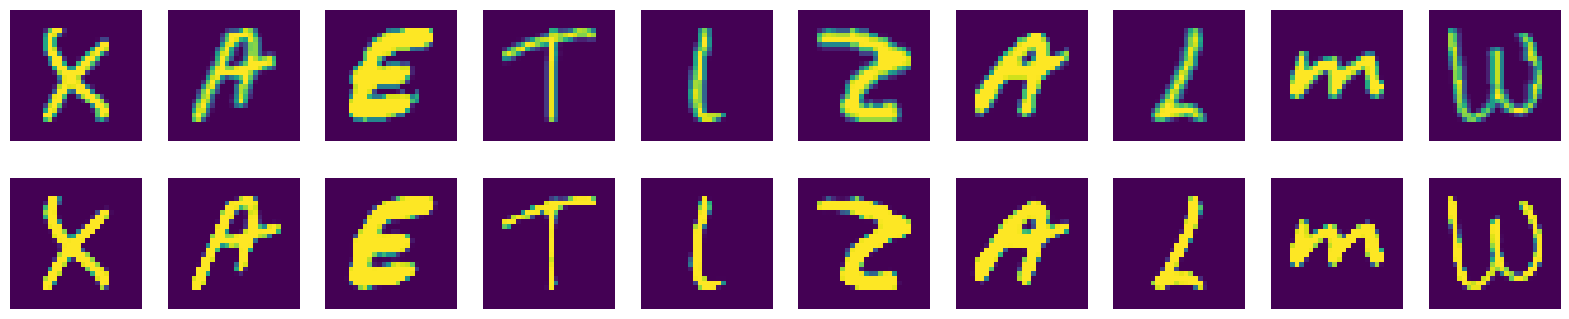

In [15]:

if INTERACTIVE_SESSION:
    display_sample_images(x_test, decoded_imgs, conf.img_shape)
    

In [16]:
model.evaluate(x=x_test)


   1/1801 [..............................] - ETA: 28:49 - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

  14/1801 [..............................] - ETA: 7s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan   

  28/1801 [..............................] - ETA: 6s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

  40/1801 [..............................] - ETA: 6s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

  52/1801 [..............................] - ETA: 6s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

  66/1801 [>.............................] - ETA: 6s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

  80/1801 [>.............................] - ETA: 6s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

  94/1801 [>.............................] - ETA: 6s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 108/1801 [>.............................] - ETA: 6s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 122/1801 [=>............................] - ETA: 6s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 135/1801 [=>............................] - ETA: 6s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 149/1801 [=>............................] - ETA: 6s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 162/1801 [=>............................] - ETA: 6s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 177/1801 [=>............................] - ETA: 6s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 189/1801 [==>...........................] - ETA: 6s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 204/1801 [==>...........................] - ETA: 6s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 219/1801 [==>...........................] - ETA: 5s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 233/1801 [==>...........................] - ETA: 5s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 241/1801 [===>..........................] - ETA: 6s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 258/1801 [===>..........................] - ETA: 5s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 273/1801 [===>..........................] - ETA: 5s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 288/1801 [===>..........................] - ETA: 5s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 301/1801 [====>.........................] - ETA: 5s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 315/1801 [====>.........................] - ETA: 5s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 326/1801 [====>.........................] - ETA: 5s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 340/1801 [====>.........................] - ETA: 5s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 356/1801 [====>.........................] - ETA: 5s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 370/1801 [=====>........................] - ETA: 5s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 382/1801 [=====>........................] - ETA: 5s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 396/1801 [=====>........................] - ETA: 5s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 409/1801 [=====>........................] - ETA: 5s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 424/1801 [======>.......................] - ETA: 5s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 438/1801 [======>.......................] - ETA: 5s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 452/1801 [======>.......................] - ETA: 5s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 466/1801 [======>.......................] - ETA: 5s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 480/1801 [======>.......................] - ETA: 5s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 494/1801 [=======>......................] - ETA: 4s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 508/1801 [=======>......................] - ETA: 4s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 520/1801 [=======>......................] - ETA: 4s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 533/1801 [=======>......................] - ETA: 4s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 544/1801 [========>.....................] - ETA: 4s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 559/1801 [========>.....................] - ETA: 4s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 573/1801 [========>.....................] - ETA: 4s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 588/1801 [========>.....................] - ETA: 4s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 600/1801 [========>.....................] - ETA: 4s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 612/1801 [=========>....................] - ETA: 4s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 627/1801 [=========>....................] - ETA: 4s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 640/1801 [=========>....................] - ETA: 4s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 653/1801 [=========>....................] - ETA: 4s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 666/1801 [==========>...................] - ETA: 4s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 679/1801 [==========>...................] - ETA: 4s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 693/1801 [==========>...................] - ETA: 4s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 708/1801 [==========>...................] - ETA: 4s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 722/1801 [===========>..................] - ETA: 4s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 737/1801 [===========>..................] - ETA: 4s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 750/1801 [===========>..................] - ETA: 4s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 764/1801 [===========>..................] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 778/1801 [===========>..................] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 791/1801 [============>.................] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 803/1801 [============>.................] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 816/1801 [============>.................] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 828/1801 [============>.................] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 843/1801 [=============>................] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 856/1801 [=============>................] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 869/1801 [=============>................] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 881/1801 [=============>................] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 894/1801 [=============>................] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 907/1801 [==============>...............] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 920/1801 [==============>...............] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 934/1801 [==============>...............] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 948/1801 [==============>...............] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 961/1801 [===============>..............] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 974/1801 [===============>..............] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 987/1801 [===============>..............] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1001/1801 [===============>..............] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1015/1801 [===============>..............] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1029/1801 [================>.............] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1044/1801 [================>.............] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1057/1801 [================>.............] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1070/1801 [================>.............] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1081/1801 [=================>............] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1100/1801 [=================>............] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1113/1801 [=================>............] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1126/1801 [=================>............] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1137/1801 [=================>............] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1151/1801 [==================>...........] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1163/1801 [==================>...........] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1175/1801 [==================>...........] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1188/1801 [==================>...........] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1198/1801 [==================>...........] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1212/1801 [===================>..........] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1226/1801 [===================>..........] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1239/1801 [===================>..........] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1253/1801 [===================>..........] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1268/1801 [====================>.........] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1282/1801 [====================>.........] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1296/1801 [====================>.........] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1310/1801 [====================>.........] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1323/1801 [=====================>........] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1338/1801 [=====================>........] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1352/1801 [=====================>........] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1365/1801 [=====================>........] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1376/1801 [=====================>........] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1389/1801 [======================>.......] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1402/1801 [======================>.......] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1416/1801 [======================>.......] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1428/1801 [======================>.......] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1443/1801 [=======================>......] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1456/1801 [=======================>......] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1469/1801 [=======================>......] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1483/1801 [=======================>......] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1497/1801 [=======================>......] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1510/1801 [========================>.....] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1524/1801 [========================>.....] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1538/1801 [========================>.....] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1553/1801 [========================>.....] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1566/1801 [=========================>....] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1578/1801 [=========================>....] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1593/1801 [=========================>....] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1606/1801 [=========================>....] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1619/1801 [=========================>....] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1632/1801 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1645/1801 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1658/1801 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1670/1801 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1683/1801 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1699/1801 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1713/1801 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1724/1801 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1738/1801 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1752/1801 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1766/1801 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1781/1801 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1796/1801 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1801/1801 [==============================] - 8s 4ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan


[0.0, 0.0, nan]

In [17]:

scores = conf.evaluate_sklearn(y_test, decoded_imgs,report=True)
print(scores)

evaluation elapsed time:___ 1.79___minutes
                     0           1  accuracy    macro avg  weighted avg
precision         1.00        0.27      0.63         0.63          0.90
recall            0.58        1.00      0.63         0.79          0.63
f1-score          0.73        0.42      0.63         0.58          0.69
support    39130264.00  6032056.00      0.63  45162320.00   45162320.00
{'Avg-precision': 0.99, 'f1-score(ODS)': 0.42}
